In [1]:
from utils import *
from envs import *
from model import *
import numpy as np
from copy import deepcopy
import argparse
import pandas as pd
import ast
parser = argparse.ArgumentParser()
parser.add_argument('--episodes', type=int, required=False, help='episodes', default=50000)
parser.add_argument('--tmax', type=int, required=False, help='tmax', default=100)

parser.add_argument('--goalcoords', type=float,nargs='+', required=False, help='goalcoords', default=[0.5])
parser.add_argument('--rsz', type=float, required=False, help='rsz', default=0.05)
parser.add_argument('--rmax', type=int, required=False, help='rmax', default=5)

parser.add_argument('--seed', type=int, required=False, help='seed', default=2020)
parser.add_argument('--pcinit', type=str, required=False, help='pcinit', default='uni')
parser.add_argument('--npc', type=int, required=False, help='npc', default=16)
parser.add_argument('--alpha', type=float, required=False, help='alpha', default=0.5)
parser.add_argument('--sigma', type=float, required=False, help='sigma', default=0.05)

parser.add_argument('--plr', type=float, required=False, help='plr', default=0.01)
parser.add_argument('--clr', type=float, required=False, help='clr', default=0.01)
parser.add_argument('--llr', type=float, required=False, help='llr', default=0.000) 
parser.add_argument('--alr', type=float, required=False, help='alr', default=0.000) 
parser.add_argument('--slr', type=float, required=False, help='slr', default=0.000)
parser.add_argument('--gamma', type=float, required=False, help='gamma', default=0.9)
parser.add_argument('--nact', type=int, required=False, help='nact', default=2)

parser.add_argument('--balpha', type=float, required=False, help='balpha', default=0.0)
parser.add_argument('--paramsindex', type=int,nargs='+', required=False, help='paramsindex', default=[0,1,2])
parser.add_argument('--noise', type=float, required=False, help='noise', default=0.000)

parser.add_argument('--datadir', type=str, required=False, help='datadir', default='./data/')
parser.add_argument('--figdir', type=str, required=False, help='figdir', default='./fig/')
parser.add_argument('--csvname', type=str, required=False, help='csvname', default='results')
args, unknown = parser.parse_known_args()


# training params
train_episodes = args.episodes
tmax = args.tmax

# env pararms
envsize = 1
maxspeed = 0.1
goalsize = args.rsz
startcoord = [-0.75]
goalcoords = args.goalcoords
seed = args.seed
initvelocity = 0.0
max_reward = args.rmax

#agent params
npc = args.npc
sigma = args.sigma
alpha = args.alpha
nact = args.nact
rsz = args.rsz

# noise params
noise = args.noise
paramsindex = args.paramsindex
piname = ''.join(map(str, paramsindex))
pcinit = args.pcinit

actor_eta = args.plr
critic_eta = args.clr
pc_eta = args.llr
sigma_eta = args.slr
constant_eta = args.alr
etas = [pc_eta, sigma_eta,constant_eta, actor_eta,critic_eta]
gamma = args.gamma
balpha = args.balpha

In [2]:
exptname = f"1D_td_online_0.0ba_0.0ns_01234p_16n_0.01plr_0.01clr_0.0001llr_0.0001alr_0.0001slr_uni_0.5a_0.05s_2a_2020s_50000e_5rmax_0.05rsz"
# [logparams, allcoords, latencys, losses] = saveload(datadir+exptname, 1, 'load')
[logparams, latencys, cumr, allcoords] = saveload('./data/'+exptname, 1, 'load')


[Us, ca1s] = saveload(f'./data/sr_{exptname}',1, 'load')

gap = 25

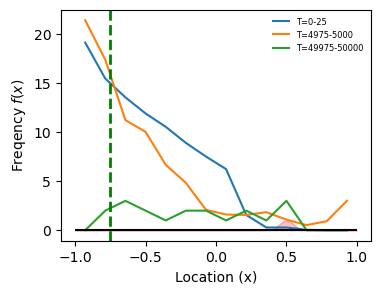

In [3]:

def plot_frequency(allcoords, trials,ax=None, goalcoord=[0.5], startcoord=[-0.75], goalsize=0.025, envsize=1, gap=25, bins=15):
    if ax is None:
        f,ax = plt.subplots()
    maxval  = 0 
    bins = np.linspace(-1,1,bins)

    for trial in trials:
        fx = []
        xx = []
        for g in range(gap):

            f, x = np.histogram(allcoords[trial-g-1], bins=bins)
            x = x[:-1] + (x[1] - x[0]) / 2
            fx.append(f)
            xx.append(x)

        fx = np.array(fx)
        xx = np.array(xx)
        xx = np.mean(xx, axis=0)
        fx = np.mean(fx, axis=0)

        ax.plot(xx, fx, label=f'T={trial-gap}-{trial}')
        maxval = max(maxval, np.max(fx) * 1.1)

    ax.set_xlabel('Location (x)')
    ax.set_ylabel('Freqency $f(x)$')
    ax.legend(frameon=False, fontsize=6)

    # ax.fill_betweenx(np.linspace(0,maxval), goalcoord[0]-goalsize, goalcoord[0]+goalsize, color='r', alpha=0.25, label='Target')
    xs = np.linspace(-1,1,1001)
    ax.fill_between(xs, reward_func(xs, goalcoord, goalsize), color='red', alpha=0.25, label='Target')
    ax.axvline(startcoord[0],ymin=0, ymax=1, color='g',linestyle='--',label='Start', linewidth=2)
    ax.hlines(xmin=-envsize,xmax=envsize, y=0, colors='k')
    
f,ax = plt.subplots(figsize=(4,3))
plot_frequency(allcoords,  [gap,5000,train_episodes], ax=ax, gap=gap, goalsize=rsz)


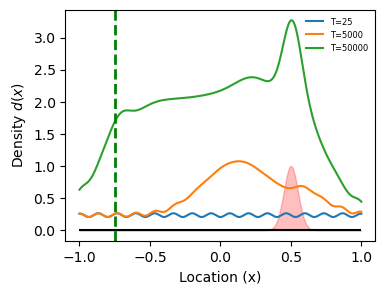

In [4]:
def plot_density(logparams, trials, ax=None, goalcoord=[0.5], startcoord=[-0.75], goalsize=0.025, envsize=1, color='k'):
    if ax is None:
        f,ax = plt.subplots()
    xs = np.linspace(-1,1,1001)

    for trial in trials:
        pcacts = predict_batch_placecell(logparams[trial], xs)
        dx = np.sum(pcacts,axis=1)
        ax.plot(xs, dx, label=f'T={trial}',color=color)

    ax.set_xlabel('Location (x)')
    ax.set_ylabel('Density $d(x)$')
    ax.legend(frameon=False, fontsize=6)

    # ax.fill_betweenx(np.linspace(0,maxval), goalcoord[0]-goalsize, goalcoord[0]+goalsize, color='r', alpha=0.25, label='Target')
    ax.fill_between(xs, reward_func(xs, goalcoord, goalsize), color='red', alpha=0.25, label='Target')
    ax.axvline(startcoord[0],ymin=0, ymax=1, color='g',linestyle='--',label='Start', linewidth=2)
    ax.hlines(xmin=-envsize,xmax=envsize, y=0, colors='k')


f,ax = plt.subplots(figsize=(4,3))
plot_density(logparams,  [gap,5000, train_episodes], ax=ax, goalsize=rsz, color=None)

[4.35022842e-04 4.36729382e-04 4.37962693e-04 ... 5.85406736e-16
 4.74077860e-16 3.83307222e-16]
[0.08261102 0.0828894  0.08307297 ... 0.01709272 0.01687245 0.01664987]
[3.35518852 3.39853995 3.44218776 ... 4.09311407 4.04288859 3.99319281]


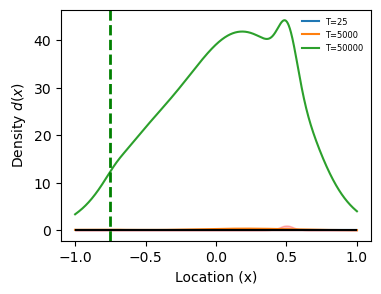

In [6]:
def plot_sr_density(ca1s, trials, ax=None, goalcoord=[0.5], startcoord=[-0.75], goalsize=0.025, envsize=1, color='k'):
    if ax is None:
        f,ax = plt.subplots()
    xs = np.linspace(-1,1,1001)

    for trial in trials:
        pcacts = np.array(ca1s[trial-1])
        dx = np.sum(pcacts,axis=1)
        print(dx)
        ax.plot(xs, dx, label=f'T={trial}',color=color)

    ax.set_xlabel('Location (x)')
    ax.set_ylabel('Density $d(x)$')
    ax.legend(frameon=False, fontsize=6)

    # ax.fill_betweenx(np.linspace(0,maxval), goalcoord[0]-goalsize, goalcoord[0]+goalsize, color='r', alpha=0.25, label='Target')
    ax.fill_between(xs, reward_func(xs, goalcoord, goalsize), color='red', alpha=0.25, label='Target')
    ax.axvline(startcoord[0],ymin=0, ymax=1, color='g',linestyle='--',label='Start', linewidth=2)
    ax.hlines(xmin=-envsize,xmax=envsize, y=0, colors='k')


f,ax = plt.subplots(figsize=(4,3))
plot_sr_density(ca1s,  [gap,5000, train_episodes], ax=ax, goalsize=rsz, color=None)

In [ ]:

def get_1D_freq_density_corr(allcoords, logparams, trial, gap=25, bins=15):
    bins = np.linspace(-0.8,0.8,bins)
    fx = []
    dx = []
    xs = []

    for g in range(gap):
        coord = allcoords[trial-g-1]
        #x = np.linspace(-1.0,1.0,bins+1)
        #coord = np.concatenate([coord[:,0], x],axis=0)
        frequency,x = np.histogram(coord, bins=bins)
        visits = x[:-1] + (x[1] - x[0])/2

        param = logparams[trial-g-1]
        pcacts = predict_batch_placecell(param, visits)
        density = np.sum(pcacts,axis=1)/pcacts.shape[1]
    
        fx.append(frequency)
        dx.append(density)
        xs.append(visits)
    
    fx = np.array(fx)
    dx = np.array(dx)
    xs = np.array(xs)

    xs = np.mean(xs,axis=0)
    dx = np.mean(dx,axis=0)
    fx = np.mean(fx,axis=0)
    R,pval = stats.pearsonr(fx, dx)
    return xs, fx, dx, R, pval
    
def plot_fxdx_trials(allcoords, logparams, trials,gap, ax=None):
    if ax is None:
        f,ax = plt.subplots()
    
    Rs = []
    for trial in trials:
        visits, frequency, density, R, pval = get_1D_freq_density_corr(allcoords, logparams, trial, gap=gap)
        Rs.append(R)
    ax.plot(trials, Rs, marker='o')
    slope, intercept, r_value, p_value, std_err = stats.linregress(np.array(trials).reshape(-1), np.array(Rs).reshape(-1))
    regression_line = slope * np.array(trials).reshape(-1) + intercept
    ax.plot(np.array(trials).reshape(-1), regression_line, color='red', label=f'R:{np.round(r_value, 3)}, P:{np.round(p_value, 3)}')
    ax.legend(frameon=False, fontsize=6)
    ax.set_title('Correlation with learning')
    ax.set_xlabel('Trial')
    ax.set_ylabel('Correlation')

plot_fxdx_trials(allcoords, logparams, np.linspace(gap, total_trials,dtype=int, num=31), ax=axs[2,2], gap=gap)


In [ ]:
plot_field_area(logparams, np.linspace(0, total_trials, num=51, dtype=int), ax=axs[3,1])


In [ ]:
plot_field_center(logparams, np.linspace(0, total_trials, num=51, dtype=int), ax=axs[3,2])
